In [8]:
#bibliotecas em uso ou usadas em algúm momento
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn import datasets
from sklearn.model_selection import train_test_split
from getTPRandFPRbyThreshold import getTPRandFPRbyThreshold
import pdb

In [9]:
def getScores(dt, label, folds):
    
    skf = StratifiedKFold(n_splits=folds)    
    clf = RandomForestClassifier(n_estimators=200) # put here the classifier algorithm that will be used as scorer
    results = []
    class_labl = []
    
    for fold_i, (train_index,valid_index) in enumerate(skf.split(dt,label)):

        tr_data = pd.DataFrame(dt.iloc[train_index])   #Train data and labels
        tr_lbl = label.iloc[train_index]
        
        valid_data = pd.DataFrame(dt.iloc[valid_index])  #Validation data and labels
        valid_lbl = label.iloc[valid_index]
        
        clf.fit(tr_data, tr_lbl)
        
        results.extend(clf.predict_proba(valid_data)[:,1])     #evaluating scores
        class_labl.extend(valid_lbl)
    
    scr = pd.DataFrame(results,columns=["score"])
    scr_labl = pd.DataFrame(class_labl, columns= ["class"])
    scores = pd.concat([scr,scr_labl], axis = 1, ignore_index= False)
    
    return scores 


In [14]:
from quantifiers.ACC import ACC
from quantifiers.PCC import PCC
from quantifiers.PACC import PACC
from quantifiers.HDy import HDy
from quantifiers.X import X
from quantifiers.MAX import MAX
from quantifiers.SMM import SMM  
from quantifiers.DyS import DyS
from quantifiers.SORD import SORD
from quantifiers.MS import MS
from quantifiers.T50 import T50
from quantifiers.EMQ import EMQ
from quantifiers.CC import CC
from quantifiers.DySyn import DySyn


"""This function is an interface for running different quantification methods.
 
Parameters
----------
qntMethod : string
    Quantification method name
p_score : array
    A numeric vector of positive scores estimated either from a validation set or from a cross-validation method.
n_score : array
    A numeric vector of negative scores estimated either from a validation set or from a cross-validation method.
test : array
    A numeric vector of scores predicted from the test set.
TprFpr : matrix
    A matrix of true positive (tpr) and false positive (fpr) rates estimated on training set, using the function getScoreKfolds().
thr : float
    The threshold value for classifying and counting. Default is 0.5.
measure : string
    Dissimilarity function name used by the DyS method. Default is "topsoe".

Returns
-------
array
    the class distribution of the test calculated according to the qntMethod quantifier. 
 """
def apply_quantifier(qntMethod, p_score, n_score,test_score, TprFpr, thr, measure, calib_clf, X_test):

    if qntMethod == "CC":
        return CC(test_score, thr)
    if qntMethod == "ACC":        
        return ACC(test_score, TprFpr)
    if qntMethod == "EMQ":      
        print("EMQ has some bugs!")
        return 0#EMQ(p_score, n_score, test_score)
    if qntMethod == "SMM":
        return SMM(p_score, n_score, test_score)
    if qntMethod == "HDy":
        return HDy(p_score, n_score, test_score)
    if qntMethod == "DyS":
        return DyS(p_score, n_score, test_score, measure)
    if qntMethod == "DySyn":
        return DySyn(test_score)
    if qntMethod == "SORD":
        return SORD(p_score, n_score, test_score)
    if qntMethod == "MS":
        return MS(test_score, TprFpr)
    if qntMethod == "MAX":
        return MAX(test_score, TprFpr)
    if qntMethod == "X":
        return X(test_score, TprFpr)
    if qntMethod == "T50":
        return T50(test_score, TprFpr)
    if qntMethod == "PCC":
        return PCC(calib_clf, X_test,thr)
    if qntMethod == "PACC":
        return PACC(calib_clf, X_test, TprFpr, thr)

In [19]:
def run_expereiment(X, y):

   #......................input/output path directories....................

   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

   
   scores = getScores(X_train, y_train, 10)
   tprfpr = getTPRandFPRbyThreshold(scores)  
   rf_clf = RandomForestClassifier(n_estimators=200)
   rf_clf.fit(X_train, y_train)   

   #>>>>>>>..............Experimental_setup............>>>>>>>>>>
   vdist = ["topsoe", "jensen_difference", "prob_symm", "ord", "sord", "hellinger"] 
   names_vdist = ["TS", "JD", "PS", "ORD", "SORD", "HD"] 
   counters    = ["HDy","DyS-TS","SORD", "MS", "CC", "ACC","SMM", "DySyn"]
   measure     = "topsoe"                   #default measure for DyS
   
   niterations = 1 #how many replicates it will take
   batch_sizes = list([20,10])#list(range(10, min(91, max_allowed + 1), 10))# + list(range(100, min(501, max_allowed + 1), 100)) # test set sizes   
   alpha_values = [round(x, 2) for x in np.linspace(0,1,10)]   #class proportion
   

   #>>>>>................calibrated_model_for PCC and PACC.......
   #splitting training set to get calibrated probabilities for PCC method.

   x_model_train, x_valid, y_model_train, y_valid = train_test_split(X_train, y_train, test_size = 0.5, stratify = y_train) 

   rf_clf2 = RandomForestClassifier(n_estimators=200)
   rf_clf2.fit(x_model_train, y_model_train)         #model is trained on new training set 
   
   calibrt_clf = CalibratedClassifierCV(rf_clf2, method="sigmoid", cv="prefit") #calibrated prbabilities
   calibrt_clf.fit(x_valid, y_valid)
   #>>>>>>>>>>>>>>>>................................>>>>>>>>>>>>>>>>>>>>

   pos_scores = scores[scores["class"]==1]["score"]
   neg_scores = scores[scores["class"]==0]["score"]
   
   df_test = pd.concat([X_test, y_test], axis=1)
   
   df_test_pos = df_test.loc[df_test['class'] == 1] # seperating positive test examples
   df_test_neg = df_test.loc[df_test['class'] == 0] # seperating negative test examples
      
   table=pd.DataFrame()
   for sample_size in batch_sizes:   #[10,100,500], batch_sizes, Varying test set sizes
    
      for alpha in alpha_values: #   Varying positive class distribution
         abs_error = []
         error = []
         for iter in range(niterations):

            pos_size = np.int(round(sample_size * alpha, 2))
            neg_size = sample_size - pos_size

            sample_test_pos = df_test_pos.sample( int(pos_size), replace = False)
            sample_test_neg = df_test_neg.sample( int(neg_size), replace = False)
            
            sample_test = pd.concat([sample_test_pos, sample_test_neg])
            test_label = sample_test["class"]
            
            test_sample = sample_test.drop(["class"], axis=1)  #dropping class label columns
            te_scores = rf_clf.predict_proba(test_sample)[:,1]  #estimating test sample scores
            
            n_pos_sample_test = list(test_label).count(1) #Counting num of actual positives in test sample
            calcultd_pos_prop = round(n_pos_sample_test/len(sample_test), 2) #actual pos class prevalence in generated sample
            
            for co in counters:               
               aux = co.split("-")
               quantifier = co
               if len(aux) > 1:
                  quantifier = aux[0]
                  measure = vdist[names_vdist.index(aux[1])]
         
               #.............Calling of Methods..................................................
               pred_pos_prop = apply_quantifier(qntMethod=quantifier, p_score=pos_scores, n_score=neg_scores, test_score=te_scores, TprFpr = tprfpr, thr = 0.5, measure = measure, calib_clf = calibrt_clf, X_test = test_sample)

               pred_pos_prop = np.round(pred_pos_prop,2)  #predicted class proportion

               #..............................RESULTS Evaluation.....................................            
               abs_error = round(abs(calcultd_pos_prop - pred_pos_prop),2) #absolute error
               error = round(calcultd_pos_prop - pred_pos_prop , 2)     # simple error Biasness
               table = table.append(pd.DataFrame([(iter + 1),sample_size,alpha,calcultd_pos_prop,pred_pos_prop,abs_error,error,quantifier]).T)

   table.columns = ["sample#","Test_size","alpha","actual_prop","pred_prop","abs_error","error_bias","quantifier"]
   return table


In [ ]:
data = datasets.load_breast_cancer()

dts = pd.DataFrame(data['data'], columns=data.feature_names) 
dts['class'] = data.target

X = dts.drop(['class'], axis=1)
y = dts['class']


result = run_expereiment(X, y)

## Plotting results

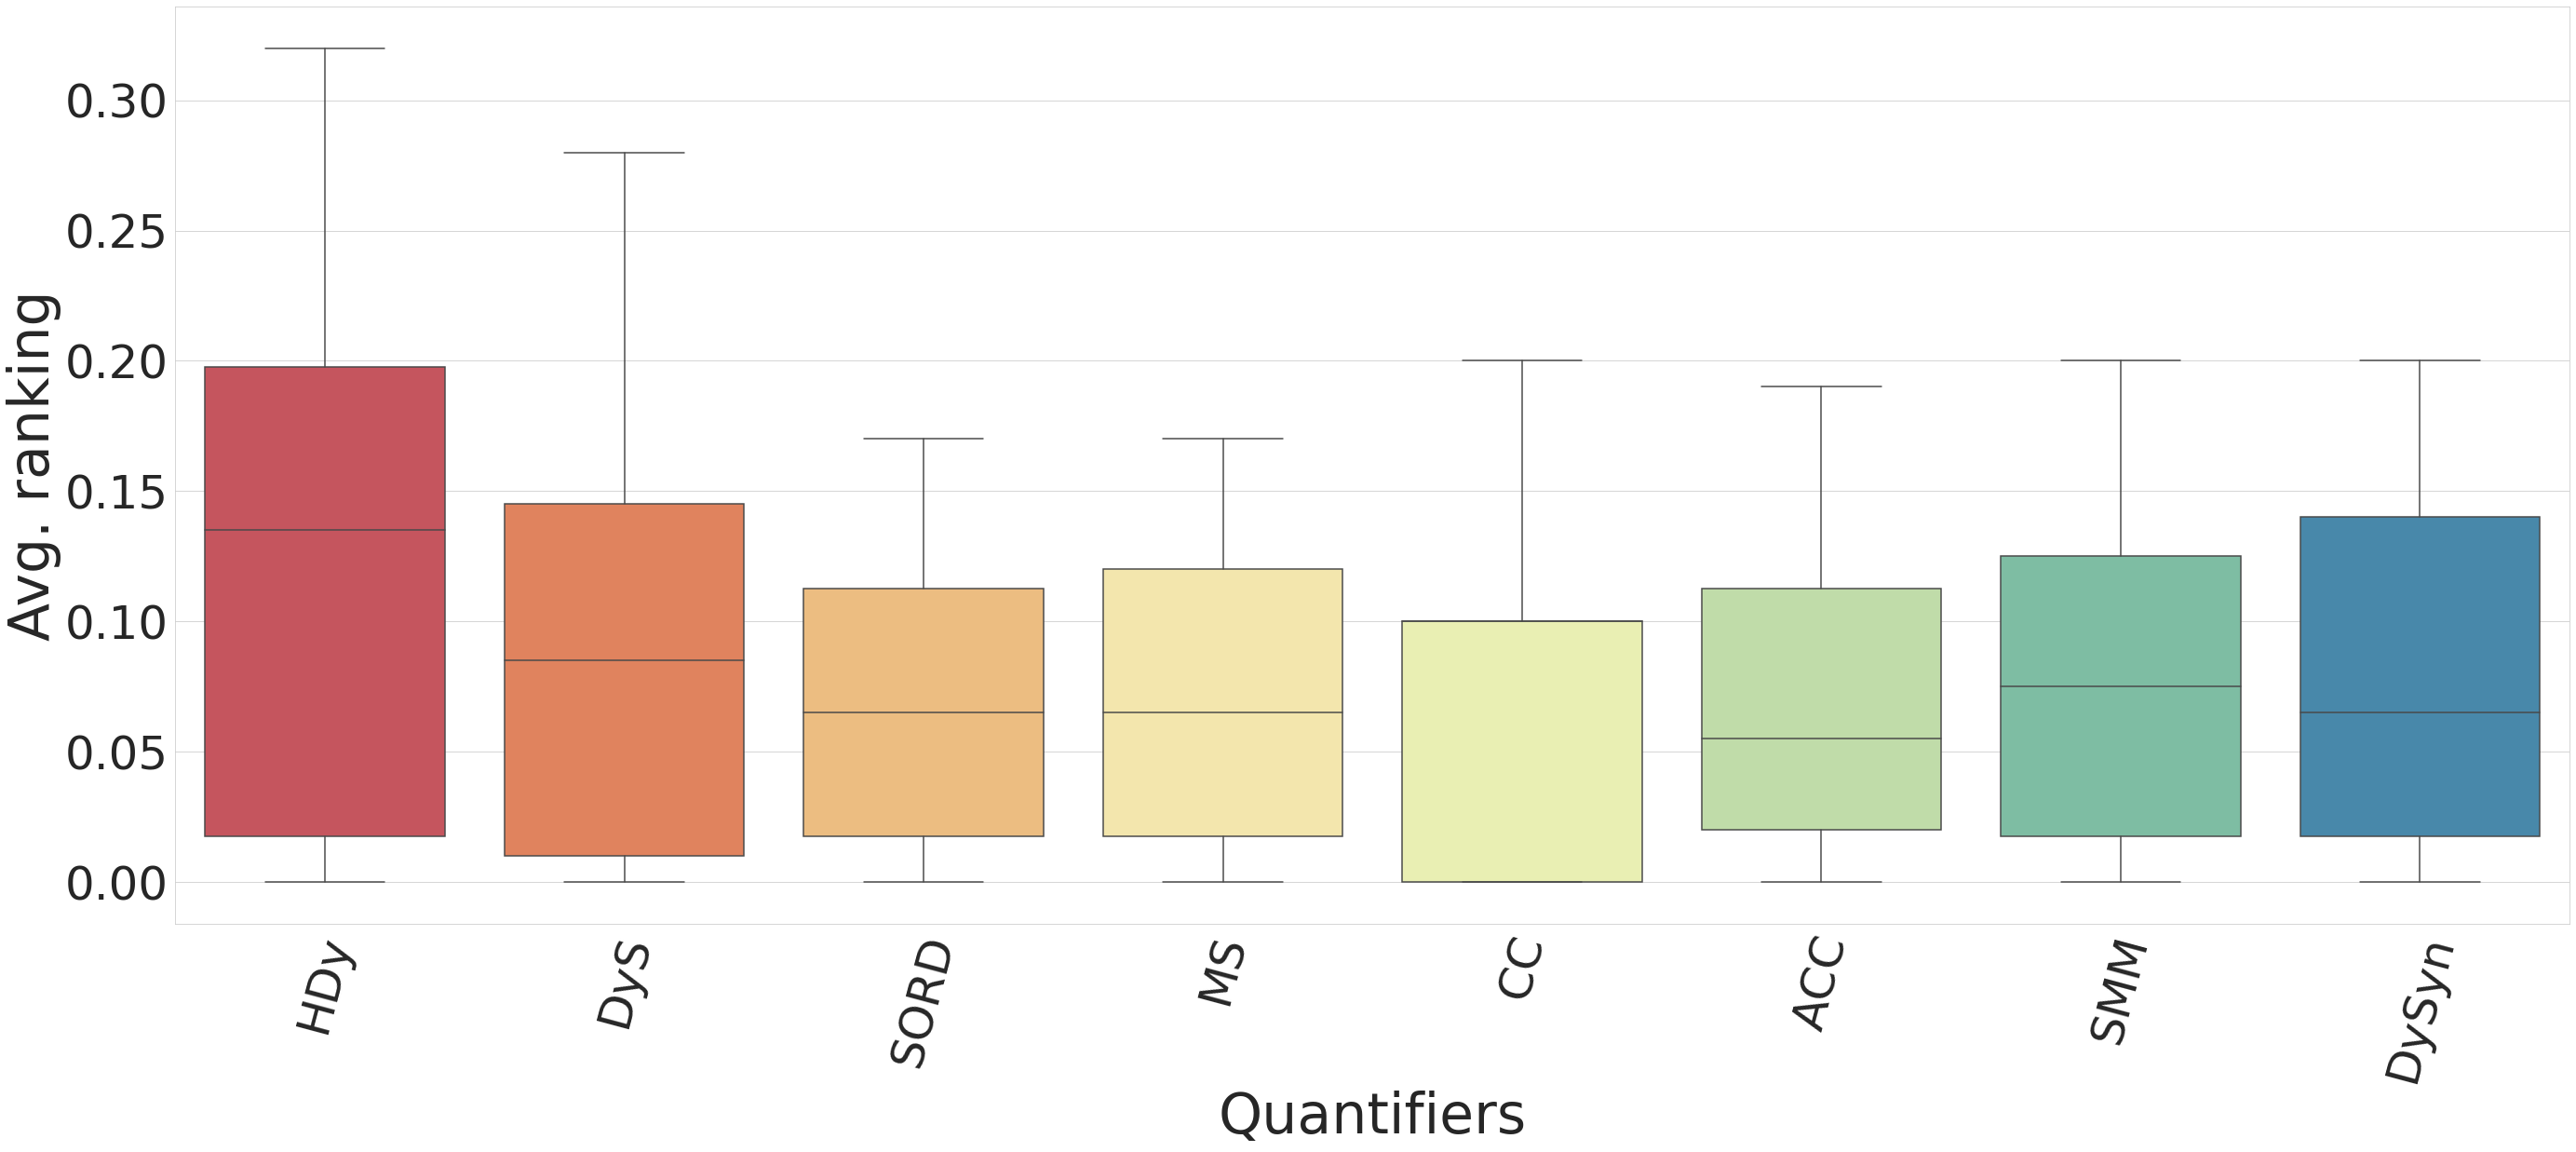

In [22]:

import  matplotlib.pyplot as plt
import seaborn as sns

sample = result
margin_left = 0.05
margin_right= 0.99
margin_top = 0.99
margin_bottom = .23
plt_width = 38
plt_heigth = 18
plot_rotation = 75
axis_font_size = 50
labels_size = 60    

with sns.axes_style("whitegrid"), sns.color_palette('Spectral', sample['quantifier'].nunique()):
    plt.figure(figsize=(plt_width,plt_heigth))
    plt.subplots_adjust(left=margin_left, bottom=margin_bottom, right=margin_right, top=margin_top)
    ax=sns.boxplot(data=sample, x='quantifier', y='abs_error') 
    plt.xticks(rotation =plot_rotation ,fontsize = axis_font_size)
    plt.yticks(fontsize = axis_font_size)    
    ax.set_xlabel("Quantifiers",fontsize=labels_size)
    ax.set_ylabel("Avg. ranking",fontsize=labels_size)   

#ax.figure.savefig(folder + '/Train_prop_%f'% (train_prop) + 'Test_size %d'% (test_size) + '.png', format="PNG" )
#ax.figure.savefig(folder + '/Overall_Rank'  + '.pdf', format="PDF" )
plt.show()